/tmp/ipython-input-1-3809151910.py:15: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mob = pd.read_csv(mobility_url, parse_dates=['date'])


 Evaluation Metrics:
Model A (COVID-only)    | MSE: 19325897.67 | R²: 0.5160
Model B (COVID+Mobility)| MSE: 45806515.36 | R²: -0.1471


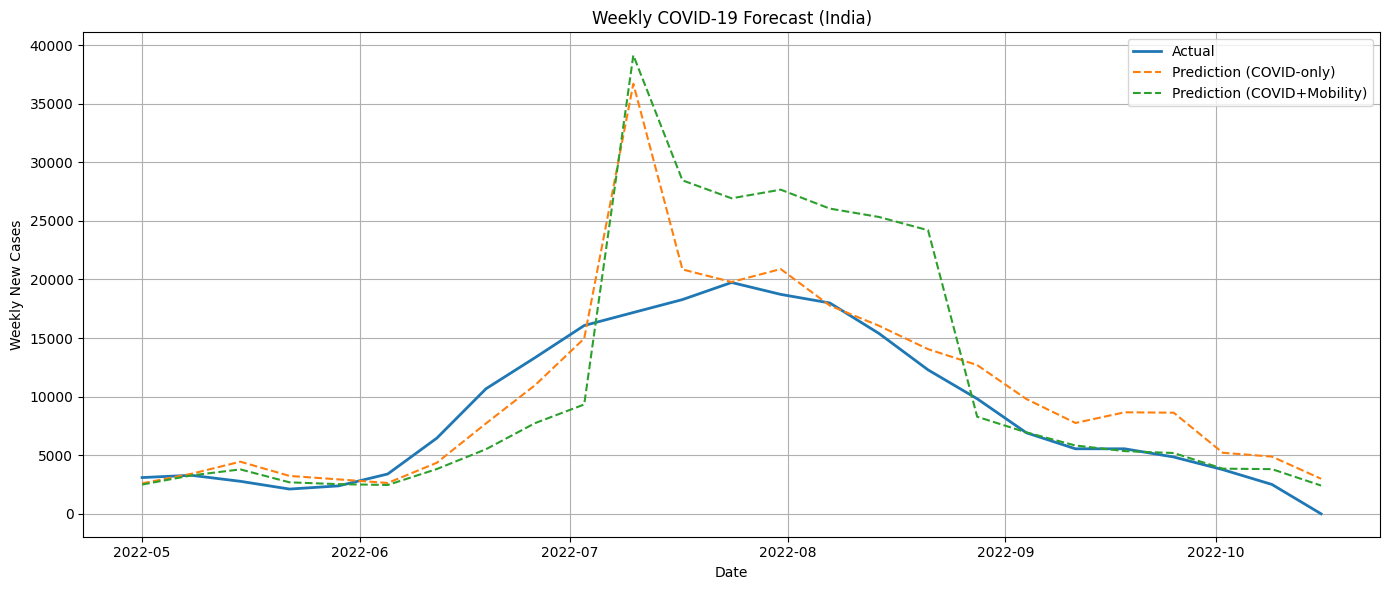

In [ ]:
# ✅ Step 1: Install packages
!pip install pandas matplotlib scikit-learn --quiet

# ✅ Step 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ✅ Step 3: Load datasets
covid_url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
mobility_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"

df_covid = pd.read_csv(covid_url, parse_dates=['date'])
df_mob = pd.read_csv(mobility_url, parse_dates=['date'])

# ✅ Step 4: Filter for India
df_covid = df_covid[df_covid['location'] == 'India'][['date', 'new_cases']]
df_mob = df_mob[(df_mob['country_region'] == 'India') & (df_mob['sub_region_1'].isna())]

# ✅ Step 5: Select required mobility columns
df_mob = df_mob[['date',
                 'workplaces_percent_change_from_baseline',
                 'residential_percent_change_from_baseline',
                 'retail_and_recreation_percent_change_from_baseline']]

# ✅ Step 6: Merge on date
df = pd.merge(df_covid, df_mob, on='date', how='inner')
df = df[df['date'] >= '2020-02-01']

# ✅ Step 7: Weekly aggregation
df.set_index('date', inplace=True)
df_weekly = df.resample('W').mean().reset_index()

# ✅ Step 8: Create lag features
for i in range(1, 5):
    df_weekly[f'lag_{i}'] = df_weekly['new_cases'].shift(i)

df_weekly.dropna(inplace=True)

# ✅ Step 9: Train-test split
train_df = df_weekly[df_weekly['date'] <= '2022-04-30']
test_df = df_weekly[df_weekly['date'] > '2022-04-30']

lag_cols = [f'lag_{i}' for i in range(1, 5)]
mob_cols = ['workplaces_percent_change_from_baseline',
            'residential_percent_change_from_baseline',
            'retail_and_recreation_percent_change_from_baseline']

X_train_A = train_df[lag_cols]
X_test_A = test_df[lag_cols]

X_train_B = train_df[lag_cols + mob_cols]
X_test_B = test_df[lag_cols + mob_cols]

y_train = train_df['new_cases']
y_test = test_df['new_cases']

# ✅ Step 10: Train models
model_A = RandomForestRegressor(random_state=0)
model_B = RandomForestRegressor(random_state=0)

model_A.fit(X_train_A, y_train)
model_B.fit(X_train_B, y_train)

# ✅ Step 11: Predict and evaluate
pred_A = model_A.predict(X_test_A)
pred_B = model_B.predict(X_test_B)

mse_A = mean_squared_error(y_test, pred_A)
r2_A = r2_score(y_test, pred_A)

mse_B = mean_squared_error(y_test, pred_B)
r2_B = r2_score(y_test, pred_B)

print(" Evaluation Metrics:")
print(f"Model A (COVID-only)    | MSE: {mse_A:.2f} | R²: {r2_A:.4f}")
print(f"Model B (COVID+Mobility)| MSE: {mse_B:.2f} | R²: {r2_B:.4f}")

# ✅ Step 12: Plot results
plt.figure(figsize=(14, 6))
plt.plot(test_df['date'], y_test, label='Actual', linewidth=2)
plt.plot(test_df['date'], pred_A, label='Prediction (COVID-only)', linestyle='--')
plt.plot(test_df['date'], pred_B, label='Prediction (COVID+Mobility)', linestyle='--')
plt.title("Weekly COVID-19 Forecast (India)")
plt.xlabel("Date")
plt.ylabel("Weekly New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
